In [1]:

import gc
import glob
import logging
import os
import random
import re
import sys
import time
import warnings
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import csv
from scipy import io
import pickle
from IPython.display import Audio, display
import os.path
import joblib
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:

data = np.load('drive/MyDrive/mfcc.npz')
X_array = data['X']
y_array = data['y']

print("X_array shape:", X_array.shape)
print("y_array shape:", y_array.shape)
print("Example label:", y_array[0])

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_array, y_array, stratify=y_array, test_size=0.2, random_state=42
)

le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

pca = PCA(n_components=34)
X_train_pca = pca.fit_transform(X_train_raw)
X_test_pca = pca.transform(X_test_raw)

X_array shape: (28564, 10240)
y_array shape: (28564,)
Example label: 1139490


In [3]:
def to_onehot(y, n_classes):
    y_bin = np.zeros((len(y), n_classes))
    for i, label in enumerate(y):
        y_bin[i, label] = 1
    return y_bin
#from ass2
def plot_roc(classes, y_true_bin, y_score):
    fpr_all = []
    tpr_all = []
    auc_all = []

    plt.figure(figsize=(10, 8))

    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=1, alpha=0.5)

        fpr_all.append(fpr)
        tpr_all.append(tpr)
        auc_all.append(roc_auc)
    valid_indices = [i for i, a in enumerate(auc_all) if not np.isnan(a)]

    all_fpr = np.unique(np.concatenate([fpr_all[i] for i in valid_indices]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in valid_indices:
        mean_tpr += interp(all_fpr, fpr_all[i], tpr_all[i])

    mean_tpr /= len(valid_indices)
    auc_val = auc(all_fpr, mean_tpr)


    macro_auc = np.nanmean(auc_all)


    plt.plot(all_fpr, mean_tpr, 'k-', lw=2)
    plt.title('MCAUC={:.4f}, AUC={:.4f}'.format(macro_auc, auc_val))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)

    return macro_auc, auc_all

Fitting 5 folds for each of 12 candidates, totalling 60 fits
best: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
acc: 0.1739891475582006
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.50      1.00      0.67         1
           9       0.00      0.00      0.00         1
          12       0.15      0.13      0.14        15
          13       0.50      0.11      0.18         9
          14       0.00      0.00      0.00        11
          15       0.00      0.00      0.00         9
          16       0.00      0.00      0.00         1
          17       0

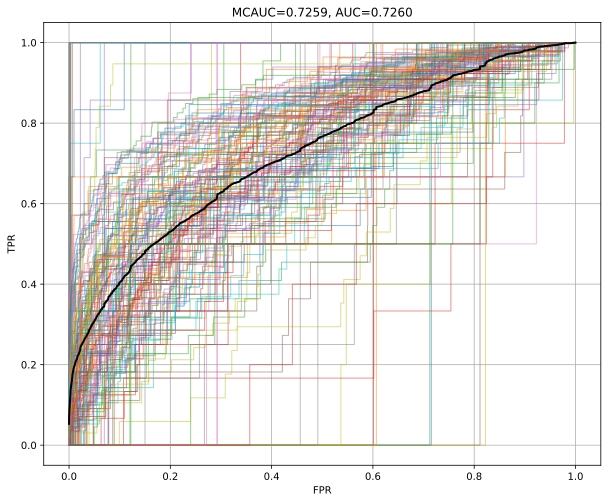

In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100,],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [ 5, 7],
    'subsample': [ 1.0],

}

xgboost = GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

xgboost.fit(X_train_pca, y_train)

y_pred = xgboost.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print("best:", xgboost.best_params_)
print("acc:", acc)
print(classification_report(y_test, y_pred))
joblib.dump(xgboost.best_estimator_, "xgboostmfcc.pkl")
print(xgboost)

y_train_proba = xgboost.predict_proba(X_train_pca)
y_test_proba = xgboost.predict_proba(X_test_pca)
classes = xgboost.classes_
n_classes = len(classes)

y_train_bin = to_onehot(y_train, n_classes)
y_test_bin = to_onehot(y_test, n_classes)

macro_auc, class_aucs = plot_roc(classes, y_test_bin, y_test_proba)
print(f"mcauc: {macro_auc:.4f}")
for i, (c, auc_val) in enumerate(zip(classes, class_aucs)):
    print(f"{c}: AUC = {auc_val:.4f}")